In [1]:
import os
cdir = os.path.abspath(os.path.dirname("__file__"))

import sys
sys.path.insert(0, cdir + "/..")

In [2]:
from __future__ import division
import pandas as pd
import numpy as np 
import matplotlib.pylab as plt
from custom_modules.organize import *
from custom_modules.roughEDA import *
from custom_modules.survey_processor_full import *
from custom_modules.model_vis import *

from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix,roc_curve
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import cross_val_score
%matplotlib inline
%load_ext autoreload
%autoreload 2

This file aims to demonstrate modelling process.

## 1.  load and process survey data

In [2]:
sv = survey('data/survey2/')

In [3]:
sv.num_processor()

In [4]:
df = sv.fin_data

In [11]:
df.shape

(4469, 144)

## 2. split target from features, then further split into training and testing data.

In [5]:
dfc = df.copy()

y = dfc.pop('employed').values
X = dfc.values

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=90)

## 3 . Modeling: fit data into Random Forest model.

In [7]:
rf=RandomForestClassifier(n_jobs = -1,random_state=0)
scores = cross_val_score(rf,X,y,cv =10, n_jobs=-1,scoring='roc_auc')
np.mean(scores)

0.76240573499327058

In [8]:
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

#### Genertate confusion matrix and roc curve.

[[256 232]
 [179 674]]


/home/yihua/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


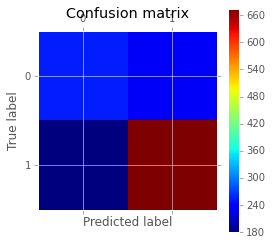

In [9]:
plot_confusion_matrix(rf,X_test,y_test)

roc_auc_score : 0.741566650011


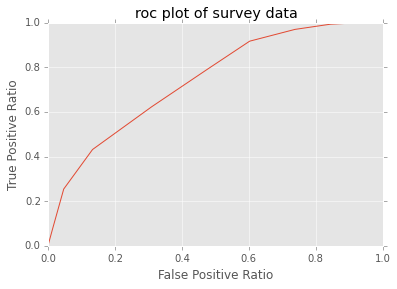

In [10]:
plot_roc(rf,X_test,y_test)

####  Important features

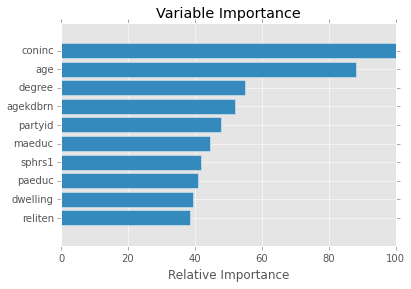

In [11]:
plot_importance(rf,dfc)

## 4.  shrink the size

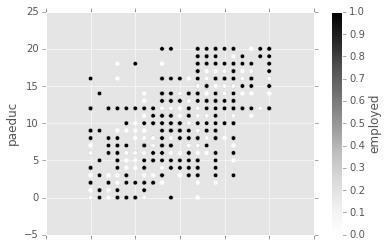

In [12]:
dfc = df.copy()
dfc.plot(x = 'maeduc', y = 'paeduc', kind = 'scatter', c = 'employed')


### mather,father,spouse highest education all rank very high.  But they are correlated somehow, so we can combine them by taking the average. This new variable can be interpreted as average family members' education. 

In [13]:
dfc = df.copy()
dfc['educom'] = (dfc.paeduc+dfc.maeduc+dfc.speduc)/3        
dfc.drop(['paeduc','maeduc','speduc'], axis =1, inplace=True)

In [14]:
y = dfc.pop('employed').values

X = dfc.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=90)

### Fit the model again

In [15]:
rf = RandomForestClassifier(n_jobs=-1,random_state=0)

In [16]:
s = cross_val_score(rf,X,y,cv =10,n_jobs=-1, scoring='roc_auc')
np.mean(s)

0.75624821100147277

In [17]:
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

roc_auc_score : 0.747375463648


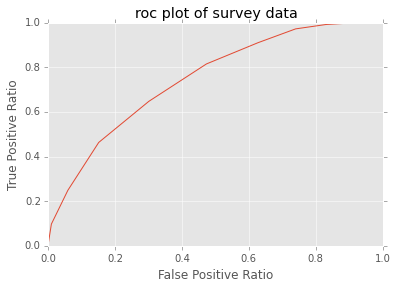

In [18]:
plot_roc(rf,X_test,y_test)

## 5. Determine how many features to keep

To determine the number of features to keep, I reduced the dimension by reduce column according to the level of feature of importance. Also, in order to classify the objects, I need to make a balance.

In [19]:
f = rf.feature_importances_.argsort()

In [20]:
clis = dfc.columns

#### Sort columns and make a new data frame

In [21]:
dfs = dfc[clis[f]].copy()

### Check first 60 import column names and specific survey questions.

In [22]:
v = dfs.columns[110:]

In [23]:
var = extract_variables('data/survey2/GSS.sps')
re_var = {k:v for (v,k) in var.iteritems()}

In [24]:
for i in v:
    if i.upper() in re_var:
        print i,':', re_var[i.upper()]

mobile16 : Geographic mobility since age 16
kidssol : Rs kids living standard compared to r
natspac : Space exploration program
meovrwrk : Men hurt family when focus on work too much
mawrkgrw : Mothers employment when r was 16
workhard : To work hard
chldidel : Ideal number of children
parsol : Rs living standard compared to parents
helpoth : To help others
fechld : Mother working doesn't hurt children
natroad : Highways and bridges
natsoc : Social security
fefam : Better for man to work, woman tend home
divorce : Ever been divorced or separated
socfrend : Spend evening with friends
natrace : Improving the conditions of blacks
finrela : Opinion of family income
fund : How fundamentalist is r currently
courts : Courts dealing with criminals
socbar : Spend evening at bar
reliten : Strength of affiliation
incom16 : Rs family income when 16 yrs old
res16 : Type of place lived in when 16 yrs old
polviews : Think of self as liberal or conservative
dwelling : Type of structure
class_ : Subjec

Run random forest model by adding one feature at a time. See at which point roc curve stays at a constant level.

In [25]:
rf_plot = RandomForestClassifier(n_jobs =-1,random_state=0)
X = dfs.values

(0, 60)

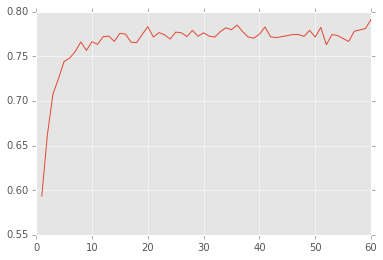

In [26]:
roclis = []
for i in f:
    if X.shape[1]==1:
        break
    X = X[:,1:]
    scores = cross_val_score(rf_plot,X,y, scoring='roc_auc',n_jobs=-1)
    roclis.append(np.mean(scores))


plt.plot(range(142,0,-1),roclis)
plt.xlim(0,60)

### take first 40 important features, make a new model

In [27]:
f30 = rf.feature_importances_.argsort()[::-1][:30]

In [28]:
rf_redu = RandomForestClassifier(n_jobs=-1,random_state=0)

In [29]:
slct=dfc.columns[f30]

In [30]:
X = dfc[slct].values

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=90)

In [32]:
s = cross_val_score(rf_redu,X,y,cv =10,n_jobs=-1,scoring='roc_auc')
np.mean(s)

0.7796888256807939

In [33]:
rf_redu.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

roc_auc_score : 0.76850147983


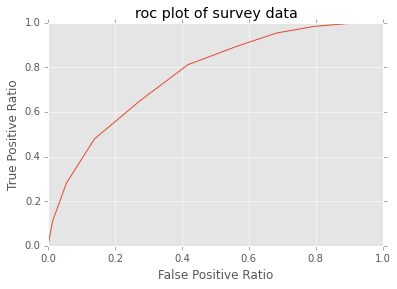

In [34]:
plot_roc(rf_redu,X_test,y_test)

## To do:
1. Grid search
2. pass it down to feature contribution algorithm

## To remember:
**train_test_split(X, y, test_size=0.3, random_state=90)**

**RandomForestClassifier(n_jobs=-1,random_state=0)**